In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 20
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode='distance', p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [5]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"] / n_neighbors
    score[element] = mean_dist

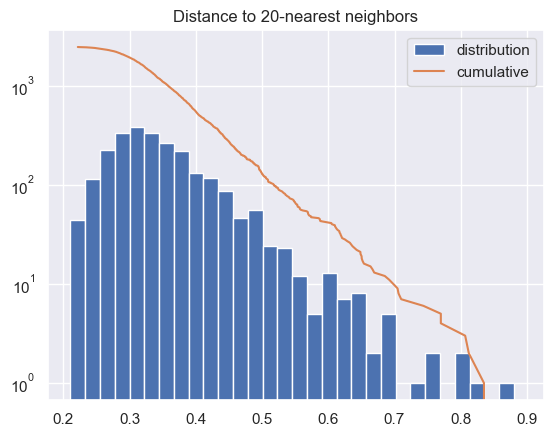

In [6]:
plt.hist(score, bins=30, align="left", label="distribution")
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)), label="cumulative")
plt.yscale('log')
plt.title(f'Distance to {n_neighbors}-nearest neighbors')
plt.legend()
plt.show()

In [7]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

(2452, 2)


66


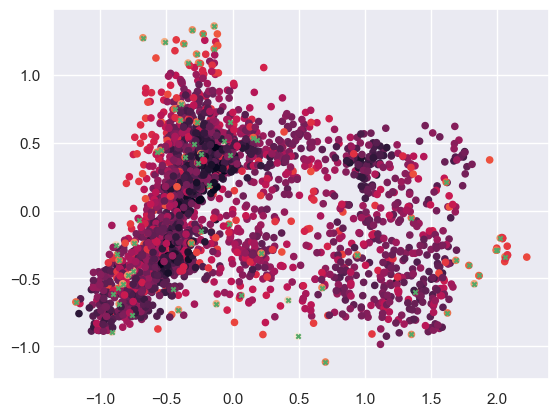

In [8]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)
plt.show()

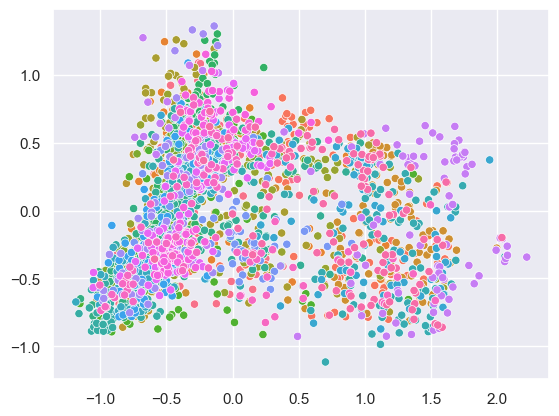

In [9]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['actor'], legend=False)
plt.show()

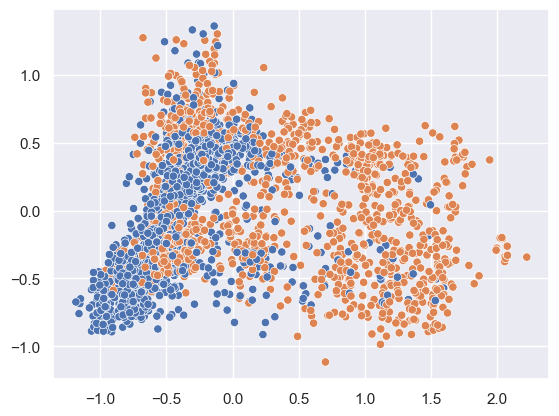

In [10]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

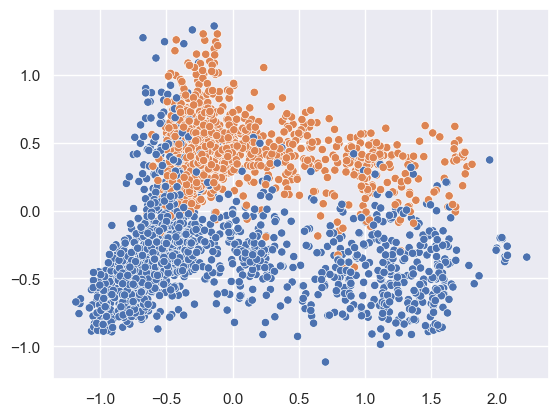

In [11]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)
plt.show()

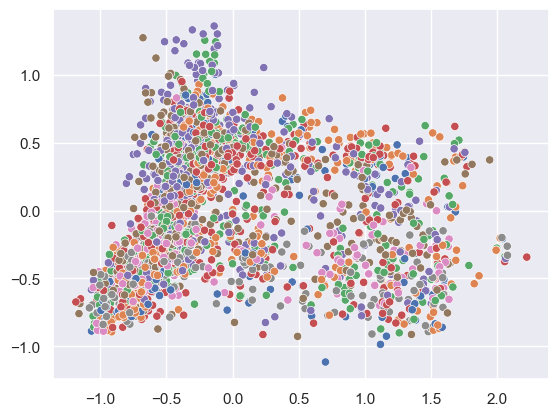

In [12]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)
plt.show()

## LOF

In [13]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [14]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_sex_m)

In [15]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  17, 1231]))

In [16]:
df_sex_m['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [17]:
clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_sex_f)

In [18]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  20, 1184]))

In [19]:
df_sex_f['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [20]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-1.041794,False
1,-0.966584,False
2,-0.986116,False
3,-1.041954,False
4,-1.004026,False
...,...,...
2447,-1.045691,False
2448,-1.114400,False
2449,-1.062986,False
2450,-1.113518,False


In [21]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [22]:
clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_speech)

In [23]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  24, 1416]))

In [24]:
df_speech['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [25]:
clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_song)

In [26]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  12, 1000]))

In [27]:
df_song['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [28]:
df['outlier_score_vc'] = df_song['outlier_score'].combine_first(df_speech['outlier_score'])
df['is_outlier_vc'] = df_song['is_outlier'].combine_first(df_speech['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-0.998850,False
1,-0.970485,False
2,-0.976422,False
3,-0.977693,False
4,-0.985296,False
...,...,...
2447,-1.003746,False
2448,-1.002312,False
2449,-1.079676,False
2450,-1.168761,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [29]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [30]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores

40     -2.957023
46     -2.787832
168    -3.171318
223    -3.085421
292    -2.739169
352    -3.614107
382    -3.579011
425    -2.991441
527    -2.633372
528    -2.812352
589    -3.385376
688    -2.756811
708    -2.800389
709    -2.677369
832    -3.210394
843    -3.056893
901    -3.014006
903    -3.147779
927    -3.220333
1194   -2.991098
1204   -2.966194
1241   -2.680327
1387   -3.110903
1420   -3.152139
1421   -3.288282
1422   -2.918016
1546   -2.991425
1702   -3.555363
1815   -3.138233
1816   -3.180376
1818   -3.610952
1819   -3.574984
1839   -2.582098
1840   -3.184684
1851   -3.285651
1861   -2.952793
1871   -3.044992
1914   -4.011975
1948   -2.981978
1968   -3.312819
1969   -3.592681
1979   -3.439580
1981   -3.300228
1982   -5.246693
2000   -3.545308
2010   -2.846725
2046   -2.906270
2210   -3.231426
2268   -2.762965
2271   -4.306768
2375   -3.046881
2383   -3.208409
2392   -3.863777
dtype: float64

In [31]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
top1pct_outliers_lof = scores.nsmallest(one_percent)
top1pct_outliers_lof

1982   -5.246693
2271   -4.306768
1914   -4.011975
2392   -3.863777
352    -3.614107
1818   -3.610952
1969   -3.592681
382    -3.579011
1819   -3.574984
1702   -3.555363
2000   -3.545308
1979   -3.439580
589    -3.385376
1968   -3.312819
1981   -3.300228
1421   -3.288282
1851   -3.285651
2210   -3.231426
927    -3.220333
832    -3.210394
2383   -3.208409
1840   -3.184684
1816   -3.180376
168    -3.171318
dtype: float64

In [32]:
df = df.drop(['outlier_score_sex', 'is_outlier_sex', 'outlier_score_vc', 'is_outlier_vc'], axis=1)

## Isolation Forest

In [33]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [34]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(df_sex_m)

In [35]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  58, 1190]))

In [36]:
df_sex_m['outlier_score'] = isfo.score_samples(df_sex_m)

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [37]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(df_sex_f)

In [38]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  52, 1152]))

In [39]:
df_sex_f['outlier_score'] = isfo.score_samples(df_sex_f)

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [40]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-0.492509,False
1,-0.416750,False
2,-0.433125,False
3,-0.436240,False
4,-0.424187,False
...,...,...
2447,-0.388608,False
2448,-0.409615,False
2449,-0.428007,False
2450,-0.413234,False


In [41]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [42]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(df_speech)

In [43]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  78, 1362]))

In [44]:
df_speech['outlier_score'] = isfo.score_samples(df_speech)

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [45]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(df_song)

In [46]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 67, 945]))

In [47]:
df_song['outlier_score'] = isfo.score_samples(df_song)

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [48]:
df['outlier_score_vc'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df['is_outlier_vc'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-0.440546,False
1,-0.426731,False
2,-0.427765,False
3,-0.411845,False
4,-0.411599,False
...,...,...
2447,-0.419453,False
2448,-0.411938,False
2449,-0.418975,False
2450,-0.440571,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [49]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [50]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores

32     -1.037525
33     -0.996115
34     -0.991548
35     -1.193547
40     -1.026105
          ...   
2234   -1.012233
2235   -1.033799
2278   -0.981321
2383   -1.000545
2391   -0.977212
Length: 163, dtype: float64

In [51]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
top1pct_outliers_isfo = scores.nsmallest(one_percent)
top1pct_outliers_isfo

243    -1.199548
35     -1.193547
1757   -1.188019
563    -1.170541
1756   -1.169988
1283   -1.164514
1862   -1.163592
1759   -1.161671
560    -1.152761
561    -1.145572
659    -1.139744
1758   -1.133814
1801   -1.126432
1975   -1.124667
1031   -1.121472
554    -1.118166
1704   -1.116899
1861   -1.108009
241    -1.106462
1973   -1.100894
240    -1.100086
308    -1.085335
302    -1.085213
311    -1.084494
dtype: float64

In [52]:
df = df.drop(['outlier_score_sex', 'is_outlier_sex', 'outlier_score_vc', 'is_outlier_vc'], axis=1)

## ABOD

In [53]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [54]:
from pyod.models.abod import ABOD

abod = ABOD()
outliers = abod.fit_predict(df_sex_m)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [55]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1123,  125]))

In [56]:
df_sex_m['outlier_score'] = abod.decision_scores_

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [57]:
abod = ABOD()
outliers = abod.fit_predict(df_sex_f)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [58]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1083,  121]))

In [59]:
df_sex_f['outlier_score'] = abod.decision_scores_

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [60]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-1.800956e-20,True
1,-8.638546e-20,True
2,-7.056687e-20,True
3,-2.800200e-20,True
4,-1.567137e-20,True
...,...,...
2447,-2.264282e-21,True
2448,-3.710962e-21,True
2449,-2.665227e-21,True
2450,-8.471607e-22,True


In [61]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [62]:
abod = ABOD()
outliers = abod.fit_predict(df_speech)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [63]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1296,  144]))

In [64]:
df_speech['outlier_score'] = isfo.score_samples(df_speech)

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [65]:
abod = ABOD()
outliers = abod.fit_predict(df_song)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [66]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([910, 102]))

In [67]:
df_song['outlier_score'] = isfo.score_samples(df_song)

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_song['is_outlier'] = is_outlier

In [68]:
df['outlier_score_vc'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df['is_outlier_vc'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-0.586333,True
1,-0.578484,True
2,-0.541745,True
3,-0.545063,True
4,-0.546561,True
...,...,...
2447,-0.419453,False
2448,-0.411938,False
2449,-0.418975,False
2450,-0.440571,True


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [69]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [70]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores

0      -0.586333
1      -0.578484
2      -0.541745
3      -0.545063
4      -0.546561
          ...   
2447   -0.419453
2448   -0.411938
2449   -0.418975
2450   -0.440571
2451   -0.447777
Length: 2315, dtype: float64

In [71]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
# using ABOD the larger the value, the more abnormal the data
top1pct_outliers_abod = scores.nlargest(one_percent)
top1pct_outliers_abod

1322   -0.373020
1326   -0.378405
1323   -0.380048
1896   -0.380613
700    -0.381131
1898   -0.382094
1113   -0.382731
164    -0.382799
1930   -0.383358
1908   -0.384073
1637   -0.384177
1899   -0.384348
1327   -0.384971
1926   -0.385493
1321   -0.385606
2445   -0.385891
2420   -0.386317
2318   -0.386577
200    -0.386579
1897   -0.386963
1648   -0.387361
1308   -0.387436
703    -0.387752
178    -0.387992
dtype: float64

In [72]:
df = df.drop(['outlier_score_sex', 'is_outlier_sex', 'outlier_score_vc', 'is_outlier_vc'], axis=1)

## Compare the outliers obtained by the three different methods

In [73]:
top1pct_outliers_lof

1982   -5.246693
2271   -4.306768
1914   -4.011975
2392   -3.863777
352    -3.614107
1818   -3.610952
1969   -3.592681
382    -3.579011
1819   -3.574984
1702   -3.555363
2000   -3.545308
1979   -3.439580
589    -3.385376
1968   -3.312819
1981   -3.300228
1421   -3.288282
1851   -3.285651
2210   -3.231426
927    -3.220333
832    -3.210394
2383   -3.208409
1840   -3.184684
1816   -3.180376
168    -3.171318
dtype: float64

In [74]:
top1pct_outliers_isfo

243    -1.199548
35     -1.193547
1757   -1.188019
563    -1.170541
1756   -1.169988
1283   -1.164514
1862   -1.163592
1759   -1.161671
560    -1.152761
561    -1.145572
659    -1.139744
1758   -1.133814
1801   -1.126432
1975   -1.124667
1031   -1.121472
554    -1.118166
1704   -1.116899
1861   -1.108009
241    -1.106462
1973   -1.100894
240    -1.100086
308    -1.085335
302    -1.085213
311    -1.084494
dtype: float64

In [75]:
top1pct_outliers_abod

1322   -0.373020
1326   -0.378405
1323   -0.380048
1896   -0.380613
700    -0.381131
1898   -0.382094
1113   -0.382731
164    -0.382799
1930   -0.383358
1908   -0.384073
1637   -0.384177
1899   -0.384348
1327   -0.384971
1926   -0.385493
1321   -0.385606
2445   -0.385891
2420   -0.386317
2318   -0.386577
200    -0.386579
1897   -0.386963
1648   -0.387361
1308   -0.387436
703    -0.387752
178    -0.387992
dtype: float64

In [77]:
common_outliers = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_isfo.index).intersection(top1pct_outliers_abod.index)
)
common_outliers

[]